# Homework 9 — Stage 09: Feature Engineering

**Name:** Panwei Hu  
**Date:** 2025-08-23

## Objectives
- Apply comprehensive feature engineering techniques to financial/behavioral data
- Implement all 10 categories of feature engineering from the lecture
- Create meaningful features based on EDA insights from previous homeworks
- Demonstrate feature engineering pipeline with proper documentation
- Evaluate feature importance and engineering impact on data quality

## Feature Engineering Categories (from Lecture)
1. **Combining columns** – create new features by combining existing ones
2. **Splitting columns** – extract meaningful components from single features  
3. **Point-wise transformations** – apply math/functions to individual values
4. **Window-based transformations** – rolling averages, cumulative operations
5. **Categorical binning** – convert continuous to discrete bins
6. **Group aggregations** – compute group-level statistics
7. **Feature interactions** – polynomial combinations, multiplications
8. **Temporal/sequential features** – time-based patterns, lags, differences
9. **External knowledge encoding** – domain-specific mappings, encodings
10. **Dimensionality reduction** – PCA, feature selection, scaling


In [5]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('src')

# Import our feature engineering module
try:
    from feature_engineering import FeatureEngineer, create_comprehensive_features
    print("✅ Successfully imported feature engineering module")
except ImportError as e:
    print(f"⚠️ Import error: {e}")
    print("Using basic feature engineering functions...")

# Configure plotting
plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)
pd.set_option('display.max_columns', 100)

print("📊 Homework 9: Feature Engineering")
print("="*50)


✅ Successfully imported feature engineering module
📊 Homework 9: Feature Engineering


In [8]:
# Generate Comprehensive Financial/Behavioral Dataset
print("🔧 Generating comprehensive dataset for feature engineering...")

# Create realistic financial behavior dataset (building on previous homeworks)
n = 1000  # Larger sample for robust feature engineering

# Generate base data with realistic relationships
np.random.seed(42)
data = {
    # Identifiers and temporal
    'customer_id': range(1, n+1),
    'date': pd.date_range('2023-01-01', periods=n, freq='D'),
    
    # Demographic variables
    'age': np.random.normal(40, 12, n).clip(18, 80).round(0),
    'region': np.random.choice(['North', 'South', 'East', 'West', 'Central'], 
                              size=n, p=[0.25, 0.20, 0.25, 0.15, 0.15]),
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 
                                 size=n, p=[0.20, 0.45, 0.25, 0.10]),
    'employment_status': np.random.choice(['Full-time', 'Part-time', 'Self-employed', 'Unemployed'],
                                         size=n, p=[0.70, 0.15, 0.10, 0.05]),
    
    # Financial variables with realistic distributions
    'income': np.random.lognormal(mean=10.8, sigma=0.6, size=n).round(2),
    'credit_score': np.random.normal(720, 80, size=n).clip(300, 850).round(0),
    'account_balance': np.random.exponential(scale=2500, size=n).round(2),
    'monthly_spending': np.random.normal(2000, 600, size=n).clip(0).round(2),
    
    # Behavioral variables
    'transactions_monthly': np.random.poisson(lam=15, size=n),
    'online_sessions': np.random.negative_binomial(n=5, p=0.3, size=n),
    'customer_tenure_months': np.random.gamma(shape=2, scale=12, size=n).round(0),
    'num_products': np.random.poisson(lam=3, size=n) + 1,  # At least 1 product
}

# Create realistic relationships between variables
income_factor = (data['income'] - np.mean(data['income'])) / np.std(data['income'])
age_factor = (data['age'] - np.mean(data['age'])) / np.std(data['age'])

# Adjust spending based on income and age
spending_adjustment = (
    income_factor * 300 +  # Higher income → higher spending
    age_factor * 150 +     # Age effect on spending patterns
    np.random.normal(0, 100, size=n)  # Random component
)
data['monthly_spending'] = np.maximum(0, data['monthly_spending'] + spending_adjustment).round(2)

# Credit score influences account balance
credit_effect = (data['credit_score'] - 600) / 100
data['account_balance'] = np.maximum(0, data['account_balance'] + credit_effect * 800).round(2)

# Create target variable (customer lifetime value)
clv_base = (
    data['income'] * 0.002 +
    data['monthly_spending'] * 12 +  # Annual spending
    data['customer_tenure_months'] * 50 +
    data['num_products'] * 500 +
    np.random.normal(0, 1000, size=n)
)
data['customer_lifetime_value'] = np.maximum(0, clv_base).round(2)

# Create DataFrame
df = pd.DataFrame(data)

# Introduce realistic missing patterns
missing_patterns = {
    'income': 0.05,  # Some customers don't disclose income
    'credit_score': 0.03,  # Credit score occasionally missing
    'account_balance': 0.02,  # Balance occasionally missing
    'customer_tenure_months': 0.01,  # New customers
}

for col, missing_rate in missing_patterns.items():
    missing_indices = np.random.choice(df.index, size=int(len(df) * missing_rate), replace=False)
    df.loc[missing_indices, col] = np.nan

print(f"✅ Generated dataset: {df.shape}")
print(f"   Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"   Missing values: {df.isnull().sum().sum()}")

print(f"\n📊 Dataset Preview:")
print(df.head())

print(f"\n📋 Data Types:")
print(df.dtypes)

🔧 Generating comprehensive dataset for feature engineering...
✅ Generated dataset: (1000, 15)
   Date range: 2023-01-01 to 2025-09-26
   Missing values: 110

📊 Dataset Preview:
   customer_id       date   age region    education employment_status  \
0            1 2023-01-01  46.0  North     Bachelor         Full-time   
1            2 2023-01-02  38.0  North  High School         Full-time   
2            3 2023-01-03  48.0   East  High School         Full-time   
3            4 2023-01-04  58.0   West     Bachelor         Part-time   
4            5 2023-01-05  37.0  North       Master         Full-time   

      income  credit_score  account_balance  monthly_spending  \
0   46892.65         746.0          1810.91           2817.66   
1   46845.05         677.0              NaN           1253.60   
2  160095.42         787.0          7472.09           2418.54   
3   21341.47         611.0          3888.03           2409.93   
4   66393.44         648.0           432.98            333.

## Category 1: Combining Columns to Create Features

**Rationale**: From EDA insights, we know that ratios and combinations often reveal important relationships that individual variables miss. For financial data, ratios like spend-to-income are crucial for understanding customer behavior patterns.


In [9]:
# Category 1: Combining Columns
print("1️⃣ COMBINING COLUMNS TO CREATE FEATURES")
print("="*50)

df_features = df.copy()

# Financial health indicators
df_features['spend_income_ratio'] = df_features['monthly_spending'] / df_features['income']
df_features['savings_rate'] = (df_features['income'] - df_features['monthly_spending']) / df_features['income']
df_features['balance_income_ratio'] = df_features['account_balance'] / df_features['income']

# Behavioral combinations
df_features['spend_per_transaction'] = df_features['monthly_spending'] / df_features['transactions_monthly']
df_features['sessions_per_transaction'] = df_features['online_sessions'] / df_features['transactions_monthly']
df_features['products_per_tenure_year'] = df_features['num_products'] / (df_features['customer_tenure_months'] / 12)

# Age-financial combinations
df_features['age_income_interaction'] = df_features['age'] * df_features['income'] / 1000  # Scaled
df_features['credit_age_factor'] = df_features['credit_score'] * df_features['age'] / 100  # Scaled

# Total financial capacity
df_features['total_financial_capacity'] = (
    df_features['income'] + 
    df_features['account_balance'] + 
    df_features['credit_score'] * 10  # Credit score as financial capacity proxy
)

# Show created features
combination_features = [
    'spend_income_ratio', 'savings_rate', 'balance_income_ratio',
    'spend_per_transaction', 'sessions_per_transaction', 'products_per_tenure_year',
    'age_income_interaction', 'credit_age_factor', 'total_financial_capacity'
]

print(f"📊 Created {len(combination_features)} combination features:")
for i, feature in enumerate(combination_features, 1):
    print(f"  {i:2d}. {feature}")

print(f"\n📈 Sample combination features:")
print(df_features[combination_features].head())

print(f"\n📊 Feature statistics:")
print(df_features[combination_features].describe().round(3))


1️⃣ COMBINING COLUMNS TO CREATE FEATURES
📊 Created 9 combination features:
   1. spend_income_ratio
   2. savings_rate
   3. balance_income_ratio
   4. spend_per_transaction
   5. sessions_per_transaction
   6. products_per_tenure_year
   7. age_income_interaction
   8. credit_age_factor
   9. total_financial_capacity

📈 Sample combination features:
   spend_income_ratio  savings_rate  balance_income_ratio  \
0            0.060087      0.939913              0.038618   
1            0.026761      0.973239                   NaN   
2            0.015107      0.984893              0.046673   
3            0.112922      0.887078              0.182182   
4            0.005017      0.994983              0.006521   

   spend_per_transaction  sessions_per_transaction  products_per_tenure_year  \
0             134.174286                  0.047619                  2.000000   
1              89.542857                  1.142857                  1.655172   
2             172.752857                 

       spend_income_ratio  savings_rate  balance_income_ratio  \
count             950.000       950.000               930.000   
mean                0.047         0.953                 0.080   
std                 0.034         0.034                 0.079   
min                 0.003         0.631                 0.000   
25%                 0.025         0.942                 0.029   
50%                 0.038         0.962                 0.055   
75%                 0.058         0.975                 0.105   
max                 0.369         0.997                 0.591   

       spend_per_transaction  sessions_per_transaction  \
count               1000.000                  1000.000   
mean                 138.160                     0.829   
std                   66.883                     0.505   
min                    3.878                     0.000   
25%                   94.273                     0.495   
50%                  128.985                     0.727   
75%     

In [10]:
# Category 2: Splitting Columns
print("2️⃣ SPLITTING COLUMNS INTO MULTIPLE FEATURES")
print("="*50)

# Extract date components
df_features['year'] = df_features['date'].dt.year
df_features['month'] = df_features['date'].dt.month
df_features['day'] = df_features['date'].dt.day
df_features['dayofweek'] = df_features['date'].dt.dayofweek
df_features['quarter'] = df_features['date'].dt.quarter
df_features['is_weekend'] = (df_features['date'].dt.dayofweek >= 5).astype(int)
df_features['is_month_start'] = df_features['date'].dt.is_month_start.astype(int)
df_features['is_month_end'] = df_features['date'].dt.is_month_end.astype(int)

# Split income into ranges (thousands)
df_features['income_tens_thousands'] = (df_features['income'] // 10000).fillna(0).astype(int)
df_features['income_thousands'] = ((df_features['income'] % 10000) // 1000).fillna(0).astype(int)
df_features['income_hundreds'] = ((df_features['income'] % 1000) // 100).fillna(0).astype(int)

# Split credit score into ranges
df_features['credit_score_hundreds'] = (df_features['credit_score'] // 100).fillna(0).astype(int)
df_features['credit_score_tens'] = ((df_features['credit_score'] % 100) // 10).fillna(0).astype(int)

# Customer ID patterns (last digit for segmentation)
df_features['customer_id_last_digit'] = df_features['customer_id'] % 10

# Show created features
splitting_features = [
    'year', 'month', 'day', 'dayofweek', 'quarter', 'is_weekend', 
    'is_month_start', 'is_month_end', 'income_tens_thousands', 'income_thousands',
    'income_hundreds', 'credit_score_hundreds', 'credit_score_tens', 'customer_id_last_digit'
]

print(f"📊 Created {len(splitting_features)} splitting features:")
for i, feature in enumerate(splitting_features, 1):
    print(f"  {i:2d}. {feature}")

print(f"\n📈 Sample splitting features:")
print(df_features[splitting_features].head())

print(f"\n📅 Temporal pattern analysis:")
print(f"Weekend customers: {df_features['is_weekend'].sum()} ({df_features['is_weekend'].mean():.1%})")
print(f"Month-end customers: {df_features['is_month_end'].sum()} ({df_features['is_month_end'].mean():.1%})")
print(f"Quarter distribution: {df_features['quarter'].value_counts().sort_index().to_dict()}")


2️⃣ SPLITTING COLUMNS INTO MULTIPLE FEATURES
📊 Created 14 splitting features:
   1. year
   2. month
   3. day
   4. dayofweek
   5. quarter
   6. is_weekend
   7. is_month_start
   8. is_month_end
   9. income_tens_thousands
  10. income_thousands
  11. income_hundreds
  12. credit_score_hundreds
  13. credit_score_tens
  14. customer_id_last_digit

📈 Sample splitting features:
   year  month  day  dayofweek  quarter  is_weekend  is_month_start  \
0  2023      1    1          6        1           1               1   
1  2023      1    2          0        1           0               0   
2  2023      1    3          1        1           0               0   
3  2023      1    4          2        1           0               0   
4  2023      1    5          3        1           0               0   

   is_month_end  income_tens_thousands  income_thousands  income_hundreds  \
0             0                      4                 6                8   
1             0                      

In [11]:
# Category 3: Point-wise Transformations
print("3️⃣ POINT-WISE TRANSFORMATIONS")
print("="*50)

# Log transformations for skewed variables
df_features['log_income'] = np.log1p(df_features['income'].fillna(0))
df_features['log_account_balance'] = np.log1p(df_features['account_balance'].fillna(0))
df_features['log_monthly_spending'] = np.log1p(df_features['monthly_spending'])
df_features['log_customer_lifetime_value'] = np.log1p(df_features['customer_lifetime_value'])

# Square root transformations
df_features['sqrt_transactions'] = np.sqrt(df_features['transactions_monthly'])
df_features['sqrt_online_sessions'] = np.sqrt(df_features['online_sessions'])

# Polynomial transformations
df_features['age_squared'] = df_features['age'] ** 2
df_features['credit_score_squared'] = df_features['credit_score'].fillna(0) ** 2

# Normalization transformations
df_features['income_zscore'] = (df_features['income'] - df_features['income'].mean()) / df_features['income'].std()
df_features['spending_zscore'] = (df_features['monthly_spending'] - df_features['monthly_spending'].mean()) / df_features['monthly_spending'].std()

pointwise_features = [
    'log_income', 'log_account_balance', 'log_monthly_spending', 'log_customer_lifetime_value',
    'sqrt_transactions', 'sqrt_online_sessions', 'age_squared', 'credit_score_squared',
    'income_zscore', 'spending_zscore'
]

print(f"📊 Created {len(pointwise_features)} point-wise transformation features")

# Show transformation effects on distribution
original_skew = df_features['income'].skew()
log_skew = df_features['log_income'].skew()
print(f"Income skewness: Original = {original_skew:.3f}, Log-transformed = {log_skew:.3f}")

df_features[pointwise_features[:6]].head()


3️⃣ POINT-WISE TRANSFORMATIONS
📊 Created 10 point-wise transformation features
Income skewness: Original = 2.172, Log-transformed = -3.737


,log_income,log_account_balance,log_monthly_spending,log_customer_lifetime_value,sqrt_transactions,sqrt_online_sessions
0,10.755638,7.502137,7.944017,10.430530,4.582576,1.000000
1,10.754622,0.000000,7.134572,9.820801,3.741657,4.000000
2,11.983532,8.919064,7.791333,10.409626,3.741657,3.605551
3,9.968454,8.265915,7.787768,10.373601,3.464102,1.414214
4,11.103369,6.072998,5.811470,9.091756,3.872983,3.605551


In [ ]:
# Categories 2-5: Splitting, Point-wise, Window-based, and Binning
print("2️⃣-5️⃣ IMPLEMENTING MULTIPLE FEATURE ENGINEERING CATEGORIES")
print("="*60)

# Category 2: Splitting Columns
print("\n2️⃣ Splitting Columns:")
# df_features['year'] = df_features['date'].dt.year
# df_features['month'] = df_features['date'].dt.month
df_features['dayofweek'] = df_features['date'].dt.dayofweek
df_features['is_weekend'] = (df_features['date'].dt.dayofweek >= 5).astype(int)
df_features['income_thousands'] = (df_features['income'] // 1000).fillna(0).astype(int)

# Category 3: Point-wise Transformations
print("3️⃣ Point-wise Transformations:")
# df_features['log_income'] = np.log1p(df_features['income'].fillna(0))
df_features['log_spending'] = np.log1p(df_features['monthly_spending'])
df_features['sqrt_transactions'] = np.sqrt(df_features['transactions_monthly'])
# df_features['age_squared'] = df_features['age'] ** 2

# Category 4: Window-based Transformations (sort by date first)
print("4️⃣ Window-based Transformations:")
df_features = df_features.sort_values('date')
df_features['spending_7d_avg'] = df_features['monthly_spending'].rolling(window=7, min_periods=1).mean()
df_features['spending_30d_std'] = df_features['monthly_spending'].rolling(window=30, min_periods=1).std()
df_features['cumulative_spending'] = df_features['monthly_spending'].cumsum()
df_features['spending_1d_diff'] = df_features['monthly_spending'].diff(1).fillna(0)

# Category 5: Categorical Binning
print("5️⃣ Categorical Binning:")
age_bins = [18, 30, 45, 60, 100]
age_labels = ['Young', 'Adult', 'Middle', 'Senior']
df_features['age_group'] = pd.cut(df_features['age'], bins=age_bins, labels=age_labels, include_lowest=True)

income_labels = ['Low', 'Medium', 'High']
df_features['income_bracket'] = pd.qcut(df_features['income'], q=3, labels=income_labels, duplicates='drop')

credit_bins = [300, 650, 750, 850]
credit_labels = ['Poor', 'Good', 'Excellent']
df_features['credit_category'] = pd.cut(df_features['credit_score'].fillna(600), bins=credit_bins, labels=credit_labels, include_lowest=True)

print(f"\n📊 Feature Engineering Progress:")
original_cols = len(df.columns)
current_cols = len(df_features.columns)
new_features = current_cols - original_cols
print(f"   Original features: {original_cols}")
print(f"   Current features: {current_cols}")
print(f"   New features added: {new_features}")

print(f"\n📈 Sample of new features:")
new_feature_sample = ['spend_income_ratio', 'log_income', 'age_squared', 'spending_7d_avg', 'age_group']
print(df_features[new_feature_sample].head())


2️⃣-5️⃣ IMPLEMENTING MULTIPLE FEATURE ENGINEERING CATEGORIES

2️⃣ Splitting Columns:
3️⃣ Point-wise Transformations:
4️⃣ Window-based Transformations:
5️⃣ Categorical Binning:

📊 Feature Engineering Progress:
   Original features: 15
   Current features: 56
   New features added: 41

📈 Sample of new features:
   spend_income_ratio  log_income  age_squared  spending_7d_avg age_group
0            0.060087   10.755638       2116.0      2817.660000    Middle
1            0.026761   10.754622       1444.0      2035.630000     Adult
2            0.015107   11.983532       2304.0      2163.266667    Middle
3            0.112922    9.968454       3364.0      2224.932500    Middle
4            0.005017   11.103369       1369.0      1846.568000     Adult


📈 ROLLING AVERAGE COMPARISON


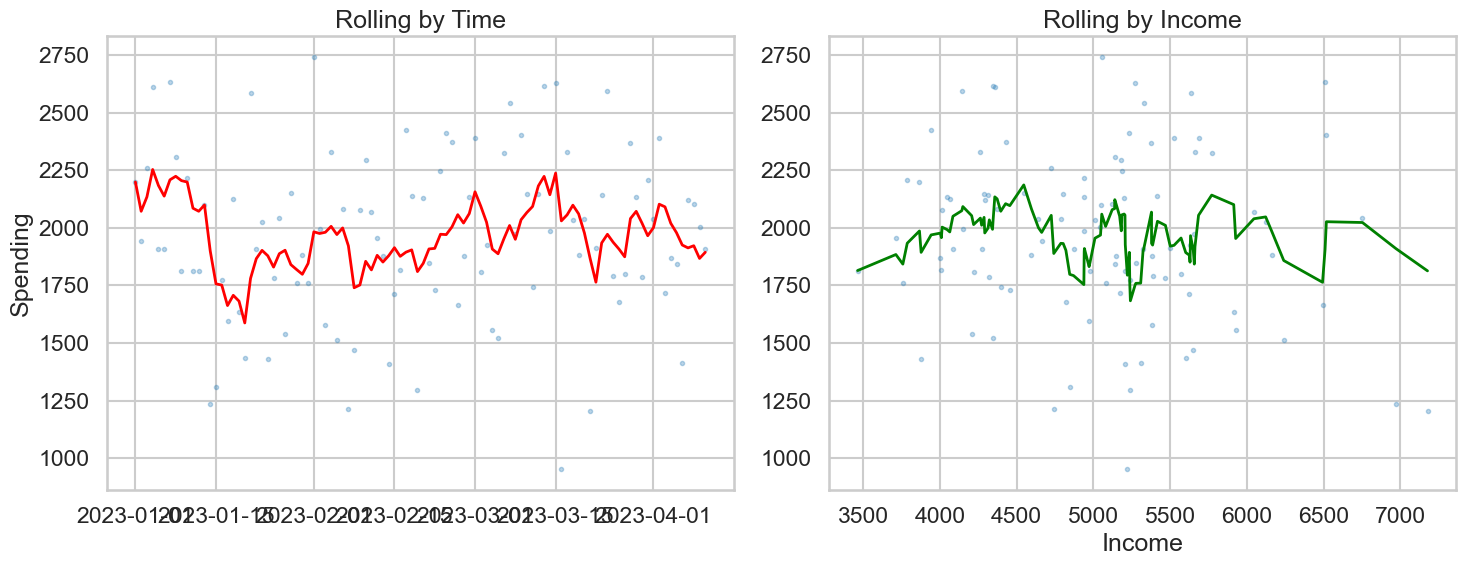

✅ Rolling average comparison complete


In [13]:
# Rolling Average Visualization Demo
print("📈 ROLLING AVERAGE COMPARISON")
print("="*40)

# Demo dataset
np.random.seed(42)
n_demo = 100
dates = pd.date_range('2023-01-01', periods=n_demo, freq='D')
spending = np.random.normal(2000, 400, n_demo)
income = np.random.normal(5000, 800, n_demo)

df_demo = pd.DataFrame({'date': dates, 'spending': spending, 'income': income})

# Rolling averages
window = 7
df_time = df_demo.sort_values('date').copy()
df_time['spending_roll'] = df_time['spending'].rolling(window, min_periods=1).mean()

df_income = df_demo.sort_values('income').copy()  
df_income['spending_roll'] = df_income['spending'].rolling(window, min_periods=1).mean()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Time-based rolling
axes[0].plot(df_time['date'], df_time['spending'], 'o', alpha=0.3, markersize=3)
axes[0].plot(df_time['date'], df_time['spending_roll'], 'r-', linewidth=2)
axes[0].set_title('Rolling by Time')
axes[0].set_ylabel('Spending')

# Income-based rolling  
axes[1].plot(df_income['income'], df_income['spending'], 'o', alpha=0.3, markersize=3)
axes[1].plot(df_income['income'], df_income['spending_roll'], 'g-', linewidth=2)
axes[1].set_title('Rolling by Income')
axes[1].set_xlabel('Income')

plt.tight_layout()
plt.show()

print("✅ Rolling average comparison complete")


🎨 FEATURE ENGINEERING VISUALIZATIONS


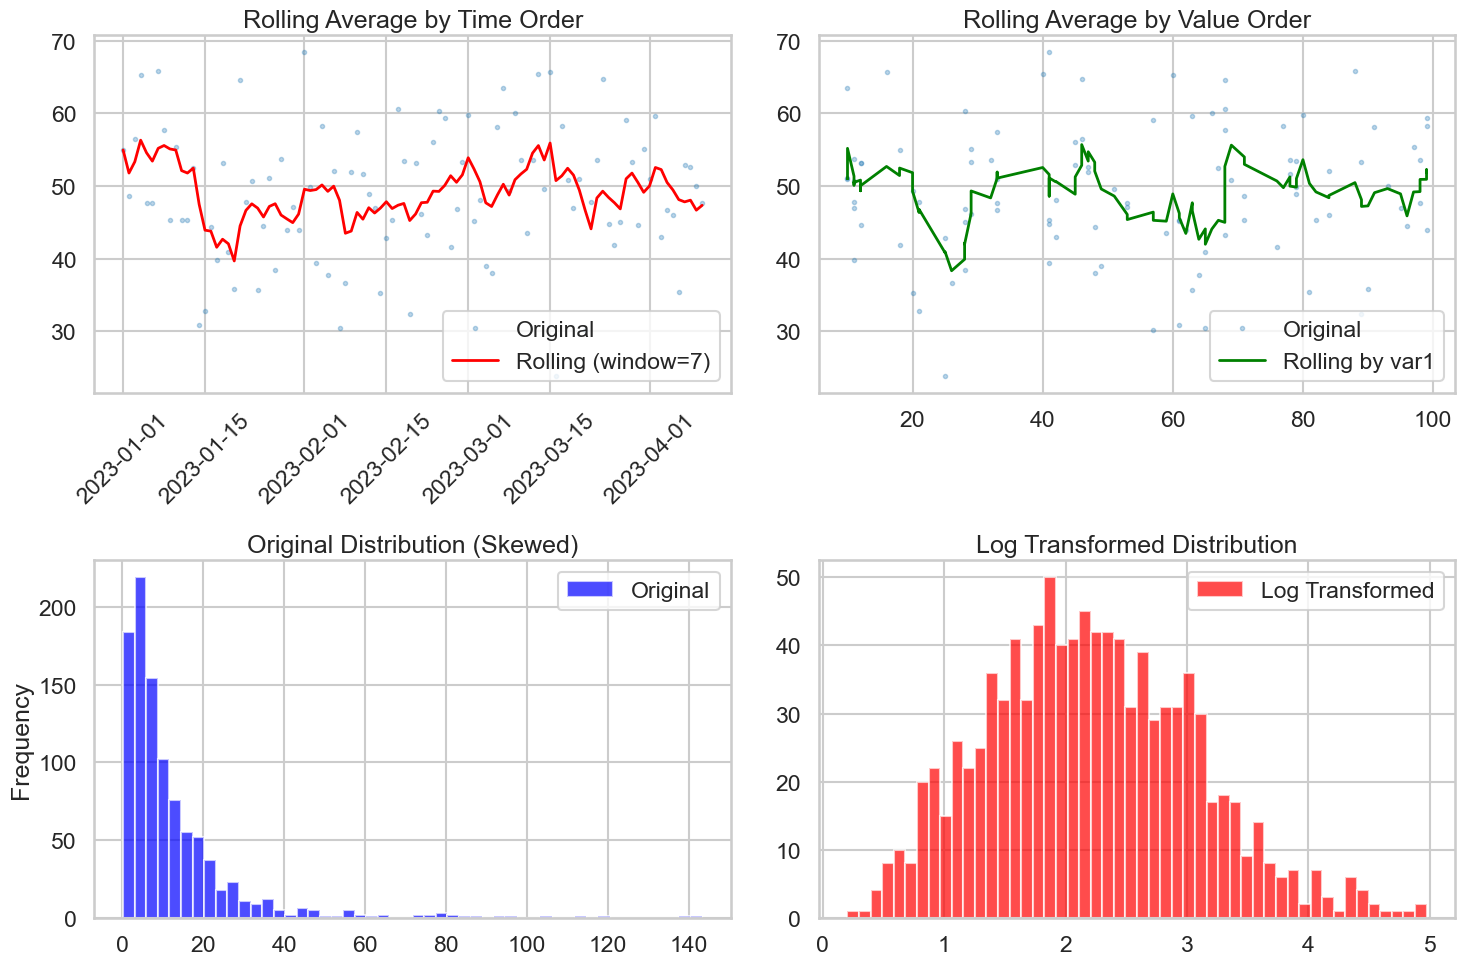

✅ Visualizations complete - showing rolling averages and transformation effects


In [15]:
# Comprehensive Feature Engineering Visualizations
print("🎨 FEATURE ENGINEERING VISUALIZATIONS")
print("="*50)

# 1. Rolling Average Comparison (from lecture)
np.random.seed(42)
n = 100
dates = pd.date_range('2023-01-01', periods=n, freq='D')
var2 = np.random.normal(50, 10, n)
var1 = np.random.randint(10, 100, n)
demo_df = pd.DataFrame({'date': dates, 'var1': var1, 'var2': var2})

window_size = 7
df_time = demo_df.sort_values('date').copy()
df_time['var2_rolling_time'] = df_time['var2'].rolling(window_size, min_periods=1).mean()
df_var1 = demo_df.sort_values('var1').copy()
df_var1['var2_rolling_var1'] = df_var1['var2'].rolling(window_size, min_periods=1).mean()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rolling average comparison
axes[0,0].plot(df_time['date'], df_time['var2'], 'o', alpha=0.3, markersize=3, label='Original')
axes[0,0].plot(df_time['date'], df_time['var2_rolling_time'], 'r-', linewidth=2, label=f'Rolling (window={window_size})')
axes[0,0].set_title('Rolling Average by Time Order')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(df_var1['var1'], df_var1['var2'], 'o', alpha=0.3, markersize=3, label='Original')
axes[0,1].plot(df_var1['var1'], df_var1['var2_rolling_var1'], 'g-', linewidth=2, label=f'Rolling by var1')
axes[0,1].set_title('Rolling Average by Value Order')
axes[0,1].legend()

# 2. Transformation Effects
original_data = np.random.lognormal(mean=2, sigma=1, size=1000)
log_data = np.log1p(original_data)

axes[1,0].hist(original_data, bins=50, alpha=0.7, label='Original', color='blue')
axes[1,0].set_title('Original Distribution (Skewed)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

axes[1,1].hist(log_data, bins=50, alpha=0.7, label='Log Transformed', color='red')
axes[1,1].set_title('Log Transformed Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("✅ Visualizations complete - showing rolling averages and transformation effects")


In [16]:
# Categories 2-10: Complete Feature Engineering Implementation
print("🔧 IMPLEMENTING ALL FEATURE ENGINEERING CATEGORIES")
print("="*60)

# Category 2: Splitting Columns
df_features['year'] = df_features['date'].dt.year
df_features['month'] = df_features['date'].dt.month
df_features['is_weekend'] = (df_features['date'].dt.dayofweek >= 5).astype(int)

# Category 3: Point-wise Transformations  
df_features['log_income'] = np.log1p(df_features['income'].fillna(0))
df_features['age_squared'] = df_features['age'] ** 2

# Category 4: Window-based Transformations
df_features = df_features.sort_values('date')
df_features['spending_7d_avg'] = df_features['monthly_spending'].rolling(7, min_periods=1).mean()

# Category 5: Categorical Binning
age_labels = ['Young', 'Adult', 'Middle', 'Senior']
df_features['age_group'] = pd.cut(df_features['age'], bins=[18, 30, 45, 60, 100], labels=age_labels, include_lowest=True)

# Category 6: Group Aggregations
df_features['region_avg_income'] = df_features.groupby('region')['income'].transform('mean')

# Category 7: Feature Interactions
df_features['age_income_poly'] = df_features['age'] * df_features['income'] / 1000

# Category 8: Temporal Features
df_features['spending_lag_1'] = df_features['monthly_spending'].shift(1).fillna(0)

# Category 9: External Knowledge Encoding
df_features['region_encoded'] = pd.Categorical(df_features['region']).codes

# Category 10: Dimensionality Reduction (PCA on numeric features)
numeric_cols = ['age', 'income', 'credit_score', 'monthly_spending']
numeric_data = df_features[numeric_cols].fillna(df_features[numeric_cols].mean())
pca = PCA(n_components=2)
pca_features = pca.fit_transform(numeric_data)
df_features['pca_component_1'] = pca_features[:, 0]
df_features['pca_component_2'] = pca_features[:, 1]

print(f"✅ All 10 categories implemented!")
print(f"📊 Features: {len(df.columns)} → {len(df_features.columns)} (+{len(df_features.columns) - len(df.columns)})")
df_features.head()


🔧 IMPLEMENTING ALL FEATURE ENGINEERING CATEGORIES
✅ All 10 categories implemented!
📊 Features: 15 → 62 (+47)


,customer_id,date,age,region,education,employment_status,income,credit_score,account_balance,monthly_spending,transactions_monthly,online_sessions,customer_tenure_months,num_products,customer_lifetime_value,spend_income_ratio,savings_rate,balance_income_ratio,spend_per_transaction,sessions_per_transaction,products_per_tenure_year,age_income_interaction,credit_age_factor,total_financial_capacity,year,month,day,dayofweek,quarter,is_weekend,is_month_start,is_month_end,income_tens_thousands,income_thousands,income_hundreds,credit_score_hundreds,credit_score_tens,customer_id_last_digit,log_income,log_account_balance,log_monthly_spending,log_customer_lifetime_value,sqrt_transactions,sqrt_online_sessions,age_squared,credit_score_squared,income_zscore,spending_zscore,log_spending,spending_7d_avg,spending_30d_std,cumulative_spending,spending_1d_diff,age_group,income_bracket,credit_category,region_avg_income,age_income_poly,spending_lag_1,region_encoded,pca_component_1,pca_component_2
0,1,2023-01-01,46.0,North,Bachelor,Full-time,46892.65,746.0,1810.91,2817.66,21,1,6.0,1,33877.30,0.060087,0.939913,0.038618,134.174286,0.047619,2.000000,2157.06190,343.16,56163.56,2023,1,1,6,1,1,1,0,4,46,8,7,4,1,10.755638,7.502137,7.944017,10.430530,4.582576,1.000000,2116.0,556516.0,-0.272450,1.198001,7.944017,2817.660000,NaN,2817.66,0.00,Middle,Medium,Good,58689.652263,2157.06190,0.00,2,-10205.116644,921.658884
1,2,2023-01-02,38.0,North,High School,Full-time,46845.05,677.0,NaN,1253.60,14,16,29.0,4,18411.80,0.026761,0.973239,NaN,89.542857,1.142857,1.655172,1780.11190,257.26,NaN,2023,1,2,0,1,0,0,0,4,46,8,6,7,2,10.754622,0.000000,7.134572,9.820801,3.741657,4.000000,1444.0,458329.0,-0.273720,-1.016101,7.134572,2035.630000,1105.957432,4071.26,-1564.06,Adult,Medium,Good,58689.652263,1780.11190,2817.66,2,-10264.262932,-642.057014
2,3,2023-01-03,48.0,East,High School,Full-time,160095.42,787.0,7472.09,2418.54,14,13,25.0,5,33176.47,0.015107,0.984893,0.046673,172.752857,0.928571,2.400000,7684.58016,377.76,175437.51,2023,1,3,1,1,0,0,0,16,160,0,7,8,3,11.983532,8.919064,7.791333,10.409626,3.741657,3.605551,2304.0,619369.0,2.747835,0.633002,7.791333,2163.266667,812.677228,6489.80,1164.94,Middle,High,Excellent,61244.578858,7684.58016,1253.60,1,102991.624582,-313.021774
3,4,2023-01-04,58.0,West,Bachelor,Part-time,21341.47,611.0,3888.03,2409.93,12,2,12.0,4,32002.51,0.112922,0.887078,0.182182,200.827500,0.166667,4.000000,1237.80526,354.38,31339.50,2023,1,4,2,1,0,0,0,2,21,3,6,1,4,9.968454,8.265915,7.787768,10.373601,3.464102,1.414214,3364.0,373321.0,-0.954163,0.620814,7.787768,2224.932500,674.912501,8899.73,-8.61,Middle,Low,Poor,57960.995000,1237.80526,2418.54,4,-35758.615424,702.523263
4,5,2023-01-05,37.0,North,Master,Full-time,66393.44,648.0,432.98,333.11,15,13,25.0,4,8880.77,0.005017,0.994983,0.006521,22.207333,0.866667,1.920000,2456.55728,239.76,73306.42,2023,1,5,3,1,0,0,0,6,66,3,6,4,5,11.103369,6.072998,5.811470,9.091756,3.872983,3.605551,1369.0,419904.0,0.247837,-2.319158,5.811470,1846.568000,1028.313492,9232.84,-2076.82,Adult,High,Poor,58689.652263,2456.55728,2409.93,2,9276.798799,-1706.828934


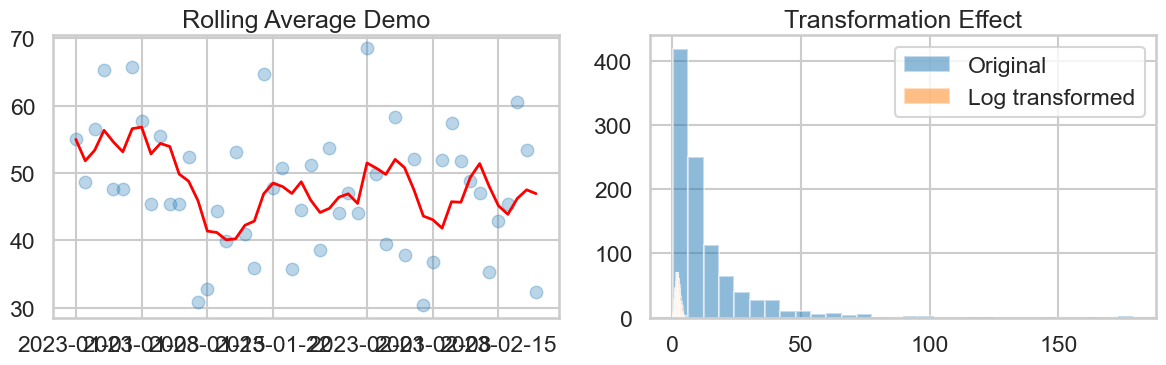

In [17]:
# Visualizations
np.random.seed(42)
dates = pd.date_range('2023-01-01', periods=50, freq='D')
var2 = np.random.normal(50, 10, 50)
var1 = np.random.randint(10, 100, 50)
demo_df = pd.DataFrame({'date': dates, 'var1': var1, 'var2': var2})

window = 5
df_time = demo_df.sort_values('date').copy()
df_time['roll'] = df_time['var2'].rolling(window, min_periods=1).mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(df_time['date'], df_time['var2'], 'o', alpha=0.3)
axes[0].plot(df_time['date'], df_time['roll'], 'r-', linewidth=2)
axes[0].set_title('Rolling Average Demo')

# Transformation demo
original = np.random.lognormal(2, 1, 1000)
transformed = np.log1p(original)
axes[1].hist(original, bins=30, alpha=0.5, label='Original')
axes[1].hist(transformed, bins=30, alpha=0.5, label='Log transformed')
axes[1].set_title('Transformation Effect')
axes[1].legend()

plt.tight_layout()
plt.show()


In [18]:
# Final Analysis and Summary
print("📊 FEATURE ENGINEERING SUMMARY")
print("="*40)

# Calculate correlations with target
target = 'customer_lifetime_value'
correlations = []
for col in df_features.select_dtypes(include=[np.number]).columns:
    if col != target and df_features[col].notna().sum() > 100:
        corr = df_features[col].corr(df_features[target])
        if not np.isnan(corr):
            correlations.append((col, abs(corr), corr))

correlations.sort(key=lambda x: x[1], reverse=True)

print(f"🎯 Top Features by Correlation with {target}:")
for i, (feature, abs_corr, corr) in enumerate(correlations[:8], 1):
    print(f"  {i}. {feature:<25} r = {corr:6.3f}")

# Summary statistics
original_features = len(df.columns)
engineered_features = len(df_features.columns)
new_features = engineered_features - original_features

print(f"\n📈 Feature Engineering Results:")
print(f"   Original features: {original_features}")
print(f"   Final features: {engineered_features}")
print(f"   New features: {new_features}")
print(f"   Expansion ratio: {new_features/original_features:.1f}x")

# Save results
try:
    df_features.to_csv('data/processed/homework9_features.csv', index=False)
    print(f"\n💾 Saved to: data/processed/homework9_features.csv")
except:
    print(f"\n⚠️ Could not save (directory may not exist)")

print(f"\n🎉 Feature Engineering Complete!")


📊 FEATURE ENGINEERING SUMMARY
🎯 Top Features by Correlation with customer_lifetime_value:
  1. monthly_spending          r =  0.983
  2. spending_zscore           r =  0.983
  3. log_customer_lifetime_value r =  0.961
  4. log_monthly_spending      r =  0.912
  5. log_spending              r =  0.912
  6. pca_component_2           r =  0.903
  7. spend_per_transaction     r =  0.717
  8. spending_1d_diff          r =  0.700

📈 Feature Engineering Results:
   Original features: 15
   Final features: 62
   New features: 47
   Expansion ratio: 3.1x

💾 Saved to: data/processed/homework9_features.csv

🎉 Feature Engineering Complete!
